In [2]:
import os
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Data Download

In [3]:
# 결과물을 저장할 폴더를 만듭니다.
path = ['data', 'model', 'result', 'img']
for i in path:
    if not os.path.exists(i):
        os.mkdir(i)

In [4]:
if not os.path.exists('data/train.csv'):
    !kaggle competitions download -c playground-series-s5e5
    !unzip playground-series-s5e5.zip -d data
    !rm playground-series-s5e5.zip
    !kaggle datasets download ruchikakumbhar/calories-burnt-prediction
    !unzip calories-burnt-prediction.zip -d data
    !rm calories-burnt-prediction.zip

In [5]:
import sgml, sgpp, dproc, sgutil

import polars as pl
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

sc = sgutil.SGCache('img', 'result', 'model')

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, ShuffleSplit

from scipy.stats import kruskal

# Data processing

**Task**

- Train / Test / Org 데이터를 불러오는 루틴 디자인합니다.
- Calories를 Log 변환하고 이 변수를 Calories_Log로 합니다.

In [7]:
p = make_pipeline(
    sgpp.PolarsProcessor(),
    sgpp.PandasConverter(index_col = 'id')
)
df_train = p.fit_transform(['data/train.csv']).assign(
    Calories_Log = lambda x: np.log(x['Calories'] + 1)
)
df_train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Calories_Log
id,,,,,,,,,
0,male,36,189.0,82.0,26.0,101.0,41.000000,150.0,5.017280
1,female,64,163.0,60.0,8.0,85.0,39.700001,34.0,3.555348
2,female,51,161.0,64.0,7.0,84.0,39.799999,29.0,3.401197
3,male,20,192.0,90.0,25.0,105.0,40.700001,140.0,4.948760
4,female,38,166.0,61.0,25.0,102.0,40.599998,146.0,4.990433


- 테스트 데이터를 불러 옵니다.

In [8]:
df_test = p.transform(['data/test.csv'])
df_test.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
id,,,,,,,
750000,male,45,177.0,81.0,7.0,87.0,39.799999
750001,male,26,200.0,97.0,20.0,101.0,40.500000
750002,female,29,188.0,85.0,16.0,102.0,40.400002
750003,female,39,172.0,73.0,20.0,107.0,40.599998
750004,female,30,173.0,67.0,16.0,94.0,40.500000


- 원본 데이터를 불러 옵니다.

In [9]:
p_org = make_pipeline(
    sgpp.PolarsProcessor(),
    sgpp.PandasConverter(index_col = 'User_ID')
)
df_org = p_org.fit_transform(['data/calories.csv']).reset_index(drop=True).pipe(
    lambda x: x.set_index(-(x.index + 1))
)
df_org.head()

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
-1,male,68,190.0,94.0,29.0,105.0,40.799999,231.0
-2,female,20,166.0,60.0,14.0,94.0,40.299999,66.0
-3,male,69,179.0,79.0,5.0,88.0,38.700001,26.0
-4,female,34,179.0,71.0,13.0,100.0,40.500000,71.0
-5,female,27,154.0,58.0,10.0,81.0,39.799999,35.0


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   Sex           750000 non-null  category
 1   Age           750000 non-null  int8    
 2   Height        750000 non-null  float32 
 3   Weight        750000 non-null  float32 
 4   Duration      750000 non-null  float32 
 5   Heart_Rate    750000 non-null  float32 
 6   Body_Temp     750000 non-null  float32 
 7   Calories      750000 non-null  float32 
 8   Calories_Log  750000 non-null  float32 
dtypes: category(1), float32(7), int8(1)
memory usage: 24.3 MB


In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 750000 to 999999
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Sex         250000 non-null  category
 1   Age         250000 non-null  int8    
 2   Height      250000 non-null  float32 
 3   Weight      250000 non-null  float32 
 4   Duration    250000 non-null  float32 
 5   Heart_Rate  250000 non-null  float32 
 6   Body_Temp   250000 non-null  float32 
dtypes: category(1), float32(5), int8(1)
memory usage: 6.2 MB


In [12]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, -1 to -15000
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Gender      15000 non-null  category
 1   Age         15000 non-null  int8    
 2   Height      15000 non-null  float32 
 3   Weight      15000 non-null  float32 
 4   Duration    15000 non-null  float32 
 5   Heart_Rate  15000 non-null  float32 
 6   Body_Temp   15000 non-null  float32 
 7   Calories    15000 non-null  float32 
dtypes: category(1), float32(6), int8(1)
memory usage: 498.2 KB


# Train / Test의 유사도 파악

- Train / Test 를 분류하는 모델을 만들어 구분 성능을 측정하여 유사 정도를 파악합니다.


In [21]:
X = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'] 
X_cat = ['Sex']

result = pd.concat([
    df_train[X].assign(is_train = True), 
    df_test[X].assign(is_train = False)
], axis = 0).pipe(
    lambda x: cross_validate(
        lgb.LGBMClassifier(verbose = 0), x[X], x['is_train'], scoring = 'roc_auc', 
        cv = StratifiedShuffleSplit(n_splits = 1, train_size = 0.8, random_state = 1234), params = {'categorical_feature': X_cat},
        return_train_score = True, return_estimator = True
    )
)

result

{'fit_time': array([0.68910646]),
 'score_time': array([0.09026623]),
 'estimator': [LGBMClassifier(verbose=0)],
 'test_score': array([0.49942446]),
 'train_score': array([0.54469618])}

- Train / Test 의 구분이 용이하지 않습니다. 따라서 차이가 없다고 판단됩니다.

# Org 와  Train/Test의 유사도 파악

## Test와의 유사도

- Org와 Test의 유사도를 파악하여 Org가 유효할 수 있을지 파악합니다.

In [22]:
X = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'] 
result = pd.concat([
    df_org.rename(
        columns = {'Gender': 'Sex'}
    )[X].assign(is_org = True), 
    df_test[X].assign(is_org = False)
], axis = 0).pipe(
    lambda x: cross_validate(
        lgb.LGBMClassifier(verbose = 0), x[X], x['is_org'], scoring = 'roc_auc', 
        cv = StratifiedShuffleSplit(n_splits = 1, train_size = 0.8, random_state = 1234), params = {'categorical_feature': X_cat},
        return_train_score = True, return_estimator = True
    )
)
result

{'fit_time': array([0.25553775]),
 'score_time': array([0.04268336]),
 'estimator': [LGBMClassifier(verbose=0)],
 'test_score': array([0.62949556]),
 'train_score': array([0.6932698])}

In [23]:
pd.Series(
    result['estimator'][0].feature_importances_, index = X
)

Sex            54
Age           542
Height        538
Weight        553
Duration      371
Heart_Rate    484
Body_Temp     458
dtype: int32

## Train과의 유사도

- Org / Traind의 유사도를 파악하여 Blend이 성립할지 살펴 봅니다.

In [24]:
X = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories'] 
result = pd.concat([
    df_org.rename(
        columns = {'Gender': 'Sex'}
    )[X].assign(is_org = True), 
    df_train[X].assign(is_org = False)
], axis = 0).pipe(
    lambda x: cross_validate(
        lgb.LGBMClassifier(verbose = 0), x[X], x['is_org'], scoring = 'roc_auc', 
        cv = StratifiedShuffleSplit(n_splits = 1, train_size = 0.8, random_state = 1234), params = {'categorical_feature': X_cat},
        return_train_score = True, return_estimator = True
    )
)
result

{'fit_time': array([0.71567678]),
 'score_time': array([0.11802268]),
 'estimator': [LGBMClassifier(verbose=0)],
 'test_score': array([0.62554941]),
 'train_score': array([0.69409672])}

In [25]:
pd.Series(
    result['estimator'][0].feature_importances_, index = X
)

Sex            43
Age           524
Height        493
Weight        502
Duration      195
Heart_Rate    393
Body_Temp     392
Calories      458
dtype: int32

# Target: Calories

In [26]:
df_train['Calories'].describe()

count    750000.000000
mean         88.282791
std          62.395351
min           1.000000
25%          34.000000
50%          77.000000
75%         136.000000
max         314.000000
Name: Calories, dtype: float64

- 정수로 보입니다. 확인해 보겠습니다.

In [27]:
(df_train['Calories'] - df_train['Calories'].astype('int')).value_counts()

Calories
0.0    750000
Name: count, dtype: int64

- 최소값 1 이므로 log를 그대로 적용해도 무방했습니다.

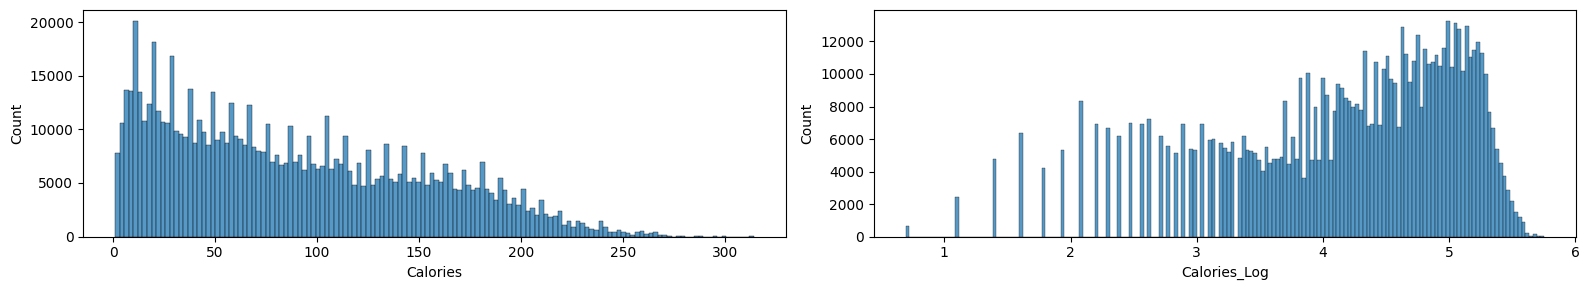

In [79]:
fig, axes = plt.subplots(1, 2, figsize = (16, 3))
sns.histplot(df_train, x = 'Calories', ax = axes[0])
sns.histplot(df_train, x = 'Calories_Log', ax = axes[1])
plt.tight_layout()
plt.show()

- Calories는 좌측으로 치우친 분포를 하고 있습니다.

- Calories_log는 4개 ~ 4개의 봉우리가 있습니다. 봉우리에 관련된 요인을 찾는 것이 도움이 될 수 있으리라 생각됩니다. 

## Calories vs Calories_Log

- LGBMRegressor 심플하게 만들고 Shuffle Split Train size 0.8로 잡아 1회 검증을 통해 결과의 차이를 비교합니다.

In [72]:
X = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'] 
result = cross_validate(
    lgb.LGBMRegressor(verbose = 0, n_estimators = 700), df_train[X], df_train['Calories'], scoring = 'neg_root_mean_squared_log_error', 
    cv = ShuffleSplit(n_splits = 1, train_size = 0.8, random_state = 1234), params = {'categorical_feature': X_cat},
    return_train_score = True, return_estimator = True
)
result

{'fit_time': array([2.32884884]),
 'score_time': array([0.65864682]),
 'estimator': [LGBMRegressor(n_estimators=700, verbose=0)],
 'test_score': array([-0.06283713]),
 'train_score': array([-0.06006336])}

In [86]:
X = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'] 
result = cross_validate(
    lgb.LGBMRegressor(verbose = 0, n_estimators = 120), df_train[X], df_train['Calories_Log'], scoring = 'neg_root_mean_squared_error', 
    cv = ShuffleSplit(n_splits = 1, train_size = 0.8, random_state = 1234), params = {'categorical_feature': X_cat},
    return_train_score = True, return_estimator = True
)
result

{'fit_time': array([0.66256213]),
 'score_time': array([0.13081861]),
 'estimator': [LGBMRegressor(n_estimators=120, verbose=0)],
 'test_score': array([-0.06239613]),
 'train_score': array([-0.06081547])}

In [87]:
X = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'] 
result = cross_validate(
    lgb.LGBMRegressor(verbose = 0, n_estimators = 700), df_train[X], df_train['Calories_Log'], scoring = 'neg_root_mean_squared_error', 
    cv = ShuffleSplit(n_splits = 1, train_size = 0.8, random_state = 1234), params = {'categorical_feature': X_cat},
    return_train_score = True, return_estimator = True
)
result

{'fit_time': array([2.2828002]),
 'score_time': array([0.66662002]),
 'estimator': [LGBMRegressor(n_estimators=700, verbose=0)],
 'test_score': array([-0.06091758]),
 'train_score': array([-0.0560343])}

- 결론: Calories_Log로 모델을 만들 때, 성능이 좋습니다. Calories를 Target으로 했을 경우, n_estimators 가  700보다 크면 과적합이 발생하기 시작한 반면,
Calories_Log로 할 경우에는 n_estimators 가 700 이후에도 test_score 가 떨어지지 않았고 teest의 성능도 Calories를 사용했을 때 보다 때 보다 좋음을 확인할 수 있었습니다.
- Calories_Log 만을 사용하여 모델을 만듭니다.


# 입력 변수 분석

In [28]:
df_train['Sex'].value_counts()

Sex
female    375721
male      374279
Name: count, dtype: int64

In [31]:
X_num = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
df_train[X_num].describe()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,41.420404,174.697647,75.145676,15.421015,95.484009,40.036243
std,15.175049,12.824495,13.982703,8.354095,9.449845,0.779875
min,20.000000,126.000000,36.000000,1.000000,67.000000,37.099998
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.599998
50%,40.000000,174.000000,74.000000,15.000000,95.000000,40.299999
75%,52.000000,185.000000,87.000000,23.000000,103.000000,40.700001
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000


In [41]:
(df_train['Age'] - df_train['Age'].astype('int')).value_counts()

Age
0    750000
Name: count, dtype: int64

In [42]:
(df_test['Age'] - df_test['Age'].astype('int')).value_counts()

Age
0    250000
Name: count, dtype: int64

In [35]:
(df_train['Height'] - df_train['Height'].astype('int')).value_counts()

Height
0.000000    749999
0.100006         1
Name: count, dtype: int64

In [36]:
(df_test['Height'] - df_test['Height'].astype('int')).value_counts()

Height
0.0    250000
Name: count, dtype: int64

In [37]:
(df_train['Weight'] - df_train['Weight'].astype('int')).value_counts()

Weight
0.0    750000
Name: count, dtype: int64

In [38]:
(df_test['Weight'] - df_test['Weight'].astype('int')).value_counts()

Weight
0.0    250000
Name: count, dtype: int64

In [39]:
(df_train['Duration'] - df_train['Duration'].astype('int')).value_counts()

Duration
0.0    750000
Name: count, dtype: int64

In [40]:
(df_test['Duration'] - df_test['Duration'].astype('int')).value_counts()

Duration
0.0    250000
Name: count, dtype: int64

- Age, 	Height,	Weight, Duration, Heart_Rate 는 정수라고 할 수 있습니다.

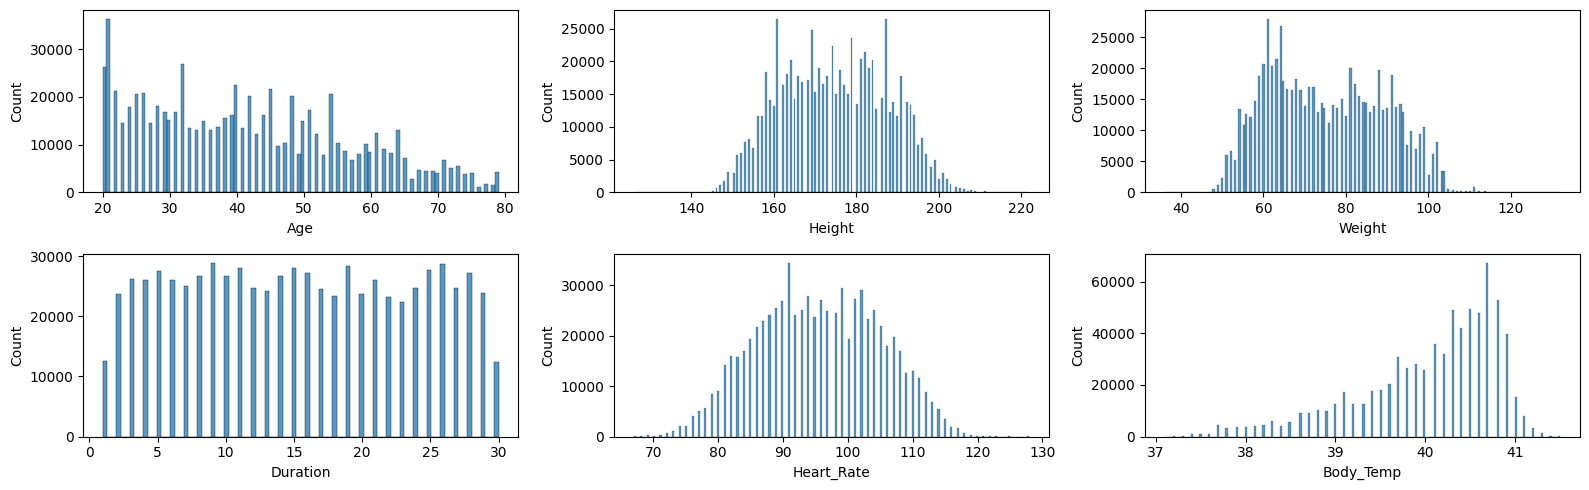

In [30]:
fig, axes = plt.subplots(2, 3, figsize = (16, 5))
axes = axes.flatten()
for i, ax in zip(X_num, axes): 
    sns.histplot(df_train, x = i, ax = ax)
plt.tight_layout()
plt.show()

- Height, Weight, Heart_Rate 에 이상치로 생각 되는 것이 보입니다.  성능과의 영향도를 살펴봅니다 .

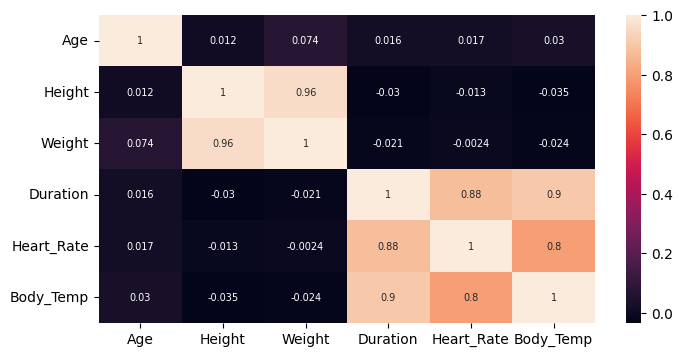

In [44]:
plt.figure(figsize = (8, 4))
sns.heatmap(
    df_train[X_num].corr(), annot = True, annot_kws = {'size' : 7}
)
plt.show()

- Height, Weight는 상관도가 0.96으로 강한 상관도 가 있고, 그 외 변수와 상관도가 떨아집니다. 

- Duration, Heart_Rate, Body_Temp는 강한 상관도 가 있습니다.

In [50]:
df_train.groupby('Sex')[X_num].agg(list).apply(
    lambda x: kruskal(*x).pvalue, axis = 0
)

Age           1.439142e-35
Height        0.000000e+00
Weight        0.000000e+00
Duration      1.339694e-17
Heart_Rate    1.544743e-06
Body_Temp     1.190521e-15
dtype: float64

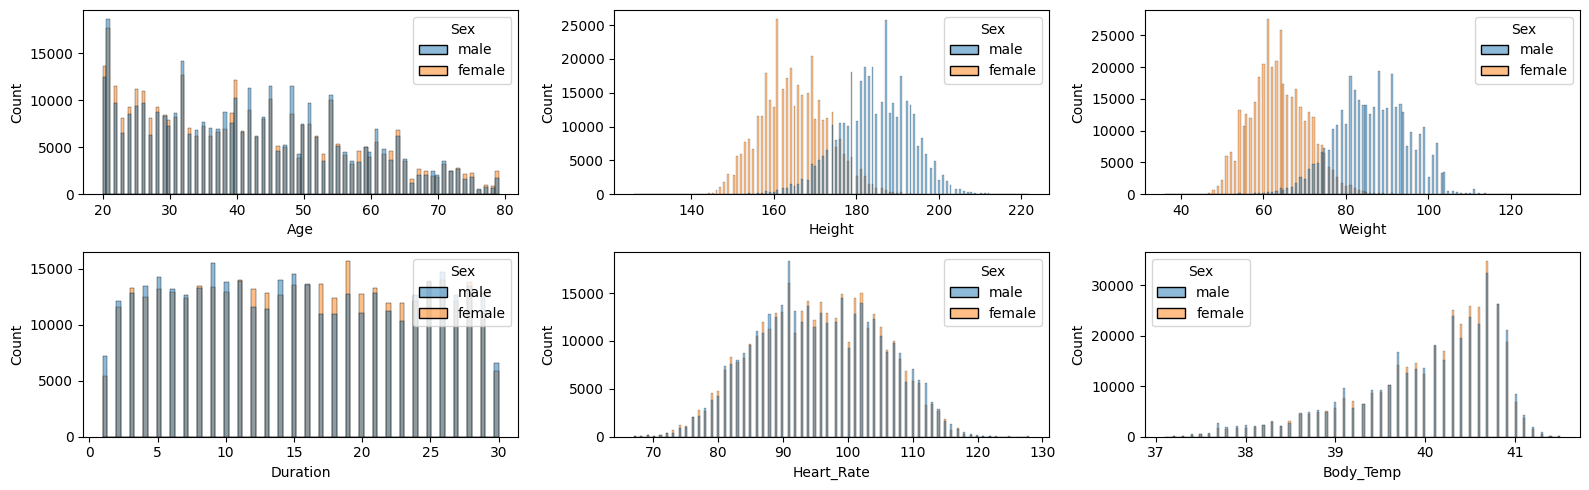

In [51]:
fig, axes = plt.subplots(2, 3, figsize = (16, 5))
axes = axes.flatten()
for i, ax in zip(X_num, axes): 
    sns.histplot(df_train, x = i, ax = ax, hue = 'Sex')
plt.tight_layout()
plt.show()

- Height, Weight는 Sex와 강한 상관도를 지니고 있습니다.

- Age, Duration, Heart_rate, Body_Temp 는 약한 상관도가 있습니다.

In [76]:
df_train[['Sex'] + X_num].value_counts().value_counts()

count
1     735018
2       6627
3        396
4         69
5         34
6          8
7          4
10         1
8          1
Name: count, dtype: int64

- 동일한 입력값이 관측이 되었습니다. target의 분산을 뽑아, 노이즈가 어느 정도 일지 측정해봅니다.

In [82]:
df_stat = df_train.groupby(['Sex'] + X_num).filter(lambda x: len(x) >= 5)\
    .groupby(['Sex'] + X_num, observed = True)['Calories_Log'].agg(['mean', 'std'])
df_stat

mean       std
Sex    Age Height Weight Duration Heart_Rate Body_Temp                    
male   21  187.0  91.0   25.0     104.0      40.799999  4.933030  0.003229
           193.0  99.0   21.0     102.0      40.700001  4.714847  0.013688
       32  187.0  92.0   15.0     102.0      40.299999  4.470400  0.015512
                         18.0     96.0       40.299999  4.458179  0.009386
           193.0  99.0   19.0     100.0      40.700001  4.670899  0.012133
       40  191.0  88.0   14.0     93.0       40.299999  4.174387  0.000000
       48  187.0  88.0   10.0     95.0       40.000000  3.973891  0.020434
                         11.0     90.0       40.000000  3.967571  0.007200
                                             40.099998  3.962598  0.017203
                                  91.0       40.000000  3.973407  0.007631
                                             40.099998  3.970292  0.000000
                  90.0   11.0     90.0       40.000000  3.967420  0.020012
                                  91.0       40.000000  3.985042  0.023943
           191.0  91.0   15.0     93.0       40.299999  4.356253  0.033666
           193.0  98.0   5.0      88.0       39.099998  3.126604  0.019879
       51  196.0  102.0  2.0      81.0       38.299999  2.079442  0.000000
       54  184.0  88.0   5.0      84.0       39.099998  3.044523  0.000000
           192.0  91.0   2.0      81.0       38.299999  2.079442  0.000000
       64  199.0  102.0  1.0      83.0       37.700001  1.609438  0.000000
female 21  169.0  64.0   9.0      91.0       39.799999  3.673689  0.013867
       32  150.0  51.0   1.0      86.0       37.700001  1.609438  0.000000
           161.0  61.0   15.0     91.0       40.299999  4.242572  0.022048
       34  163.0  62.0   21.0     99.0       40.700001  4.744932  0.000000
       40  152.0  51.0   25.0     109.0      40.700001  5.135798  0.000000
           161.0  61.0   13.0     99.0       40.299999  4.292696  0.010300
                         14.0     91.0       40.400002  4.209631  0.007650
                                  95.0       40.299999  4.295828  0.015507
                         15.0     91.0       40.299999  4.271032  0.012598
                  64.0   12.0     95.0       40.099998  4.133534  0.008764
                                  96.0       40.099998  4.155589  0.020228
                         13.0     93.0       40.099998  4.164889  0.023745
       42  161.0  60.0   16.0     91.0       40.299999  4.351548  0.007068
                  64.0   15.0     93.0       40.299999  4.317488  0.000000
       45  161.0  61.0   27.0     110.0      40.900002  5.235347  0.008790
       48  158.0  60.0   11.0     87.0       40.000000  3.912023  0.000000
                                  91.0       40.000000  3.991873  0.021485
                  61.0   11.0     89.0       40.000000  3.955053  0.008519
                                  90.0       40.000000  3.977698  0.016858
                                  91.0       40.000000  3.985245  0.008359
           161.0  60.0   11.0     91.0       40.000000  3.981473  0.012994
                                             40.099998  4.003399  0.026959
                  61.0   11.0     91.0       40.000000  3.975582  0.014231
                                             40.099998  3.977769  0.010238
                         13.0     99.0       40.299999  4.320137  0.005923
                         15.0     93.0       40.299999  4.326290  0.010758
                  64.0   11.0     91.0       40.000000  3.974030  0.008359
                  65.0   11.0     91.0       40.000000  4.003664  0.008206
       54  161.0  61.0   14.0     95.0       40.299999  4.345418  0.004562

In [83]:
df_stat['std'].mean()

0.010665245

- 약 0.01 입니다.

# ML Configuration

- Org 데이터를 포함할 지를 살펴봅니다.

- Calories_Log를 사용하고, 이를 검증하기 위해서 설정했던, LGBMClassifer n_estimators = 700 으로 성능을 비교해봅니다.

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(4, random_state = 123, shuffle = True)
X_cat = ['Sex']
X_num = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
X_all = X_cat + X_num
target = 'Calories_Log'
result = cross_val_score(
    lgb.LGBMRegressor(n_estimators = 700, verbose = 0), df_train[X_all], df_train[target], cv = kf, 
    params = {'categorical_feature': ['Sex']}, scoring = 'neg_root_mean_squared_error')
result

In [68]:
df_org = df_org.rename(columns = {'Gender': 'Sex'}).assign(
    Calories_Log = lambda x: np.log(x['Calories'])
)

In [69]:
from sklearn.metrics import root_mean_squared_error
reg_lgb = lgb.LGBMRegressor(n_estimators = 700)
rmse_oof = list()
for train_idx, valid_idx in kf.split(df_train[X_all], df_train):
    df_cv_train = pd.concat([
        df_train.iloc[train_idx], 
        df_org
    ])
    reg_lgb.fit(df_cv_train[X_all], df_cv_train[target], categorical_feature = ['Sex'])
    df_valid = df_train.iloc[valid_idx]
    rmse_oof.append(
        root_mean_squared_error(df_valid[target], reg_lgb.predict(df_valid[X_all]))
    )
rmse_oof

[0.060461383548048954,
 0.06140324584199924,
 0.059401099122018415,
 0.06121519282515802]

- 성능에는 큰 개선 효과는 보이지 않아 포함시키지 않습니다.

In [26]:
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

X_cat = ['Sex']
X_num = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
X_all = X_cat + X_num
target = 'Calories_Log'

kf = KFold(4, random_state = 123, shuffle = True)
ss = ShuffleSplit(1, random_state = 123)

def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size = validation_fraction)

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict(df[X]), index = df.index),
    'score_func': lambda df, prds: root_mean_squared_error(df[target], prds),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'y': target,
}

xgb_adapter = sgml.XGBAdapter(xgb.XGBRegressor)
lgb_adapter = sgml.LGBMAdapter(lgb.LGBMRegressor)
cb_adapter = sgml.CBAdapter(cb.CatBoostRegressor)
lr_adapter = sgml.SklearnAdapter(LinearRegression)

In [28]:
result = sgml.cv(
    df_train, kf, {'X_ohe': ['Sex'], 'ohe': {'drop': 'first'}, 'X_num': X_num}, config, lr_adapter
)
np.mean(result['valid_scores']), result['valid_scores']

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

(np.float64(0.17991552211631892),
 [np.float64(0.17983816636118022),
  np.float64(0.1795711953604901),
  np.float64(0.1796232980312847),
  np.float64(0.1806294287123207)])

In [31]:
result = sgml.cv(
    df_train, kf, 
    {'model_params': {'n_estimators': 700}, 'X_cat': ['Sex'], 'X_num': X_num}, 
    config, lgb_adapter
)
np.mean(result['valid_scores']), result['valid_scores']

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

(np.float64(0.060535573638092664),
 [np.float64(0.060286038785549556),
  np.float64(0.061383200829974255),
  np.float64(0.05933871431160542),
  np.float64(0.061134340625241416)])

- 테스트용 제출을 합니다.

In [33]:
result = sgml.train(
    df_train, {'model_params': {'n_estimators': 700}, 'X_cat': ['Sex'], 'X_num': X_num}, 
    config, lgb_adapter
)
result

({'variables': array(['ohe__Sex_male', 'pt__Age', 'pt__Height', 'pt__Weight',
         'pt__Duration', 'pt__Heart_Rate', 'pt__Body_Temp'], dtype=object),
  'train_shape': (750000, 7),
  'target': 'Calories_Log',
  'model': LGBMRegressor(n_estimators=700, verbose=-1),
  'preprocessor': ColumnTransformer(transformers=[('ohe', OneHotEncoder(drop='first'), ['Sex']),
                                  ('pt', 'passthrough',
                                   ['Age', 'Height', 'Weight', 'Duration',
                                    'Heart_Rate', 'Body_Temp'])])},
 ['Age', 'Height', 'Heart_Rate', 'Body_Temp', 'Sex', 'Weight', 'Duration'])

In [45]:
s_prd = sgml.assemble_predictor(
    **result[0], config = config, spec = result[1]
)(df_test).rename(target).pipe(lambda x: (np.exp(x) - 1).clip(lower = 1))

- 제출시에는 원래의 Target의 역변환을 수행하고 최소값을 1이 되도록 클리핑을 합니다.

- CV4: 0.0605, Pubic Score: 0.5799 가 나옵니다.

In [47]:
s_prd.to_csv('result/submission0.csv')

In [46]:
s_prd.describe()

count    250000.000000
mean         88.179397
std          62.277362
min           1.000000
25%          33.940205
50%          76.486214
75%         135.478987
max         304.558807
Name: Calories_Log, dtype: float64

In [41]:
df_train['Calories'].describe()

count    750000.000000
mean         88.282791
std          62.395351
min           1.000000
25%          34.000000
50%          77.000000
75%         136.000000
max         314.000000
Name: Calories, dtype: float64

In [ ]:
# !kaggle competitions submit -c playground-series-s5e5 -f result/submission0.csv -m "Test"

# 상관도 분석

In [49]:
kruskal(*df_train.groupby('Sex')['Calories_Log'].agg(list))

KruskalResult(statistic=np.float64(126.60265271193663), pvalue=np.float64(2.2695345023602886e-29))

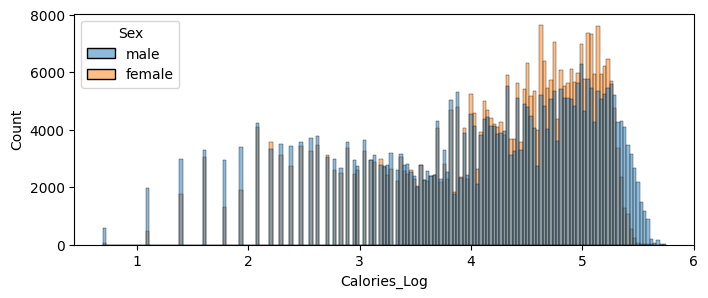

In [53]:
plt.figure(figsize = (8, 3))
sns.histplot(df_train, x = target, hue = 'Sex')
plt.show()

In [51]:
from scipy.stats import pearsonr

df_train[X_num].apply(
    lambda x: pearsonr(x, df_train[target])[0], axis = 0
)

Age           0.118512
Height       -0.042233
Weight       -0.025501
Duration      0.940128
Heart_Rate    0.881995
Body_Temp     0.952800
dtype: float32

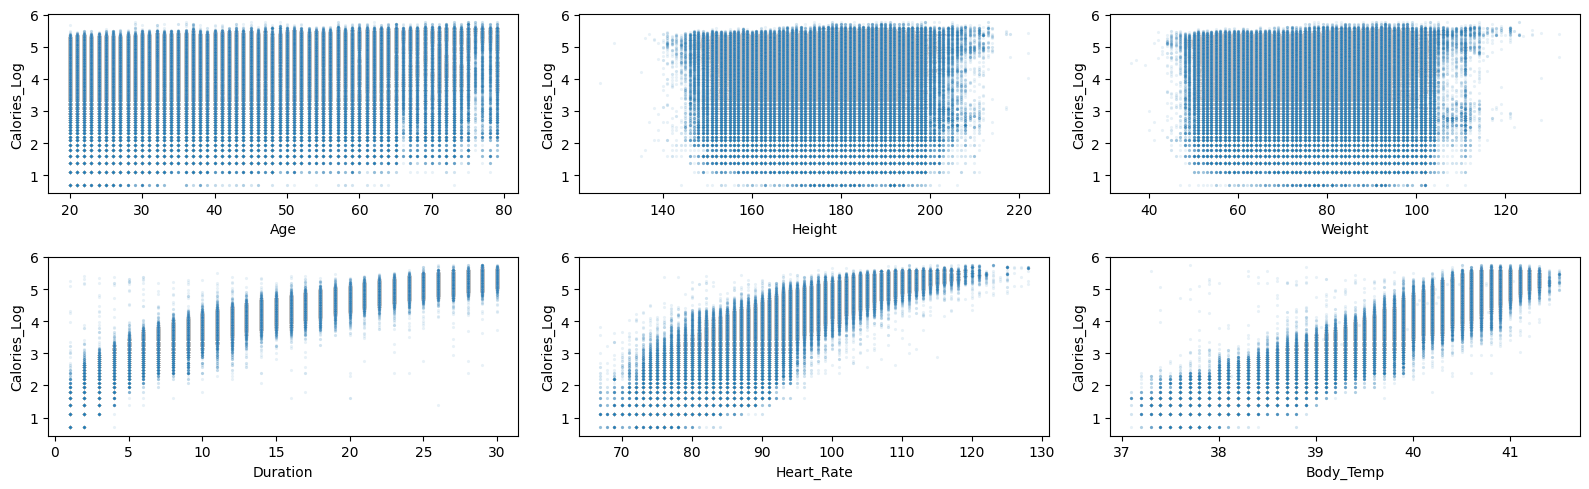

In [58]:
_, axes = plt.subplots(2, 3, figsize = (16, 5))
axes = axes.flatten()
for i, ax in zip(X_num, axes):
    sns.scatterplot(df_train, x = i, y = target, s = 5, alpha = 0.1, ax = ax)
plt.tight_layout()
plt.show()

In [52]:
result = sgml.cv(
    df_train, kf, {'X_num':['Body_Temp']}, config, lr_adapter
)
np.mean(result['valid_scores']), result['valid_scores']

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

(np.float32(0.292435),
 [np.float32(0.29283535),
  np.float32(0.2919686),
  np.float32(0.292189),
  np.float32(0.29274705)])

## Feature Interaction 조사

CatBoost의 Interaction 측정 기능을 이용하여 조사해봅니다.

In [60]:
hparams = {
    'model_params': {'max_depth': 9, 'n_estimators': 700}, 'X_cat': ['Sex'], 'X_num': X_num
}

result = sgml.cv(df_train, kf, hparams, config, cb_adapter, result_proc = [sgml.cb_interaction_importance, sgml.cb_learning_result])
np.mean(result['valid_scores']), result['valid_scores']

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

(np.float64(0.05975853754718044),
 [np.float64(0.05963939024951879),
  np.float64(0.06047363590880066),
  np.float64(0.0585060765516667),
  np.float64(0.060415047478735606)])

In [64]:
result['model_result'][0]

,Var1,Var2,Importance
0,pt__Duration,pt__Heart_Rate,21.667907
1,pt__Age,pt__Heart_Rate,9.919680
2,pt__Heart_Rate,pt__Body_Temp,7.558769
3,pt__Age,pt__Duration,7.516222
4,pt__Weight,pt__Heart_Rate,6.323176
5,pt__Duration,pt__Body_Temp,5.685216
6,pt__Age,pt__Body_Temp,4.969619
7,pt__Height,pt__Heart_Rate,4.744522
8,pt__Age,pt__Weight,4.212860
9,pt__Weight,pt__Duration,4.033067


In [90]:
result['model_result'][1]

{'valid_result': metric      RMSE
 set        learn
 0       0.828047
 1       0.710949
 2       0.611221
 3       0.525942
 4       0.453852
 ..           ...
 695     0.053935
 696     0.053933
 697     0.053927
 698     0.053925
 699     0.053915
 
 [700 rows x 1 columns],
 'feature_importance': pt__Height         0.177462
 pt__Weight         0.624996
 pt__Body_Temp      3.402781
 cat__Sex           3.416448
 pt__Age            9.194990
 pt__Heart_Rate    17.183015
 pt__Duration      66.000307
 dtype: float64,
 'variables': array(['cat__Sex', 'pt__Age', 'pt__Height', 'pt__Weight', 'pt__Duration',
        'pt__Heart_Rate', 'pt__Body_Temp'], dtype=object),
 'train_shape': (562500, 7),
 'target': 'Calories_Log',
 'preprocessor': ColumnTransformer(transformers=[('cat', 'passthrough', ['Sex']),
                                 ('pt', 'passthrough',
                                  ['Age', 'Height', 'Weight', 'Duration',
                                   'Heart_Rate', 'Body_Temp'])])}

Text(0, 0.5, 'Heart_Rate')

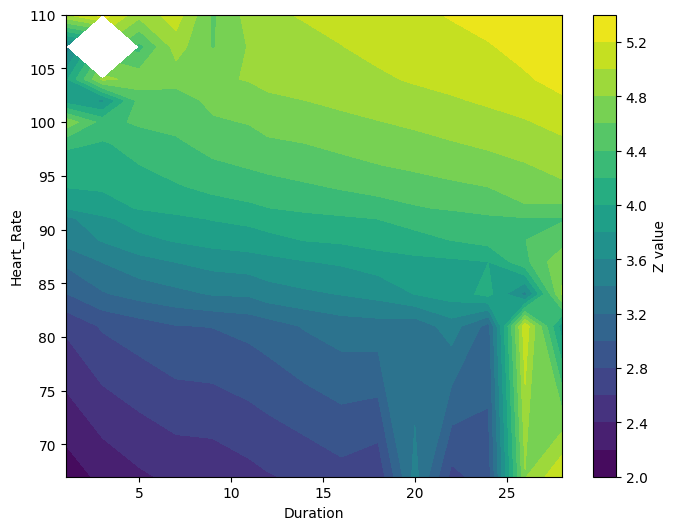

In [86]:
import matplotlib.pyplot as plt

# 1. x, y 값 범위 정의
x = df_train['Duration'].quantile(np.linspace(0, 1, 16))
y = df_train['Heart_Rate'].quantile(np.linspace(0, 1, 16))
X, Y = np.meshgrid(x.iloc[:-1], y.iloc[:-1])

# 2. z = f(x, y) 정의 (예: 이차 함수)
Z = pd.crosstab(index = pd.cut(df_train['Duration'], bins=x), columns = pd.cut(df_train['Heart_Rate'], bins=y), 
                values = df_train[target], aggfunc = 'mean')

# 3. 등고선 플롯 생성
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z, levels=20, cmap='viridis')  # 채워진 contour
plt.colorbar(contour, label='Z value')

plt.xlabel('Duration')
plt.ylabel('Heart_Rate')

<Axes: xlabel='Heart_Rate', ylabel='Duration'>

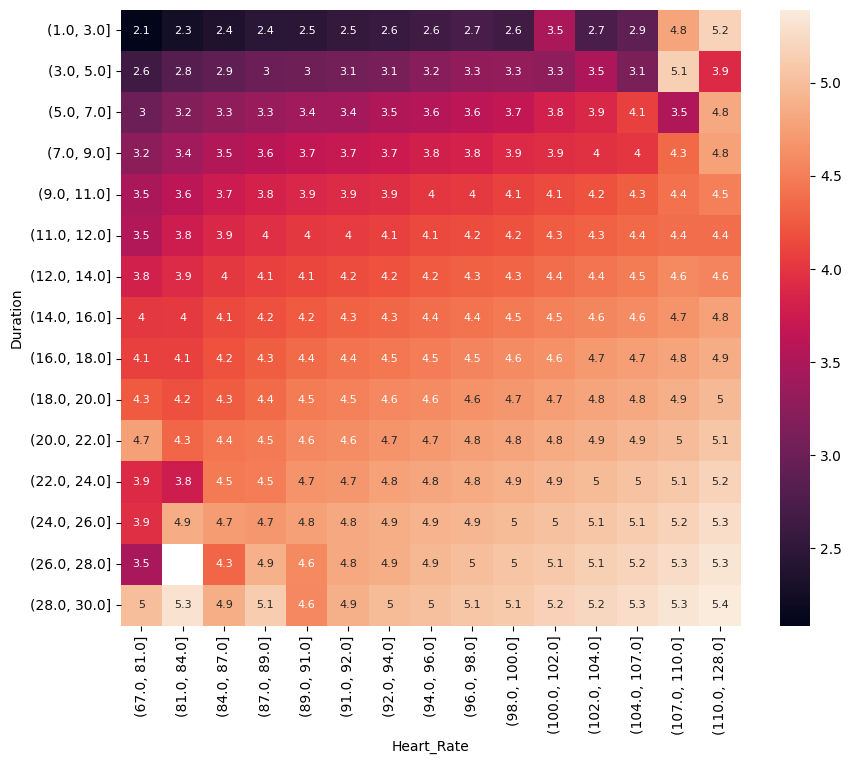

In [88]:
plt.figure(figsize = (10, 8))
sns.heatmap(Z, annot = True, annot_kws = {'size': 8})

In [89]:
pd.crosstab(index = pd.cut(df_train['Duration'], bins=x), columns = pd.cut(df_train['Heart_Rate'], bins=y))

Heart_Rate,"(67.0, 81.0]","(81.0, 84.0]","(84.0, 87.0]","(87.0, 89.0]","(89.0, 91.0]","(91.0, 92.0]","(92.0, 94.0]","(94.0, 96.0]","(96.0, 98.0]","(98.0, 100.0]","(100.0, 102.0]","(102.0, 104.0]","(104.0, 107.0]","(107.0, 110.0]","(110.0, 128.0]"
Duration,,,,,,,,,,,,,,,
"(1.0, 3.0]",20948,11941,7839,3991,3461,866,638,91,20,5,5,2,3,5,2
"(3.0, 5.0]",13752,11977,13057,6528,5262,1089,1276,327,117,26,19,11,3,5,5
"(5.0, 7.0]",6438,10859,12887,8460,6395,2047,2401,961,514,112,55,20,4,5,4
"(7.0, 9.0]",3422,6086,11545,9736,10514,3202,5647,2755,1821,431,369,77,22,10,4
"(9.0, 11.0]",1074,2660,6945,8365,11904,4359,7946,5370,3273,1501,960,247,66,15,4
"(11.0, 12.0]",245,630,2257,2841,4971,1728,4496,3535,1928,1094,741,231,77,8,8
"(12.0, 14.0]",318,999,3422,4545,7872,3584,9076,8656,4934,3359,2835,823,428,79,20
"(14.0, 16.0]",204,538,2279,2836,6040,3066,8966,10056,7515,5707,5122,1656,1040,227,47
"(16.0, 18.0]",67,135,773,1103,2461,1957,5241,7842,8507,7630,6552,3048,1993,560,160


- Body_Temp, Duration, Heart_Rate는 강한 상관 관계에 있습니다. PCA를 통한 차원 축소로 Interaction을 줄여줄때 어떤 효과가 있을 지 살펴봅니다.

In [91]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = make_pipeline(StandardScaler(), PCA())
pca.fit(df_train[['Body_Temp', 'Duration', 'Heart_Rate']])
pca[-1].explained_variance_ratio_

array([0.9056762 , 0.06864925, 0.02567451], dtype=float32)

In [97]:
hparams = {
    'model_params': {'max_depth': 9, 'n_estimators': 700}, 'X_cat': ['Sex'], 'X_num': X_num, 
    'pca': {'X_std': ['Body_Temp', 'Duration', 'Heart_Rate'], 'hparams': {'n_components': 1}},
}

result = sgml.cv(df_train, kf, hparams, config, cb_adapter, result_proc = [sgml.cb_interaction_importance, sgml.cb_learning_result])
np.mean(result['valid_scores']), result['valid_scores']

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

(np.float64(0.05994948069246081),
 [np.float64(0.05966507552302393),
  np.float64(0.0605403897686167),
  np.float64(0.05891466658123319),
  np.float64(0.06067779089696944)])

In [98]:
result['model_result'][0]

,Var1,Var2,Importance
0,pca__pca0,pt__Duration,11.888675
1,pt__Duration,pt__Heart_Rate,8.249099
2,pt__Age,pt__Heart_Rate,7.086790
3,pca__pca0,pt__Heart_Rate,6.919968
4,pca__pca0,pt__Age,6.244810
5,pt__Age,pt__Duration,5.279353
6,pt__Heart_Rate,pt__Body_Temp,5.087202
7,pt__Duration,pt__Body_Temp,5.072823
8,pca__pca0,pt__Body_Temp,4.242427
9,pt__Weight,pt__Heart_Rate,3.736116


In [99]:
hparams = {
    'model_params': {'max_depth': 9, 'n_estimators': 700}, 'X_cat': ['Sex'], 'X_num': X_num, 
    'pca': {'X_std': ['Body_Temp', 'Duration', 'Heart_Rate'], 'hparams': {'n_components': 2}},
}

result = sgml.cv(df_train, kf, hparams, config, cb_adapter, result_proc = [sgml.cb_interaction_importance, sgml.cb_learning_result])
np.mean(result['valid_scores']), result['valid_scores']

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

(np.float64(0.05999007687239304),
 [np.float64(0.059732731478921074),
  np.float64(0.0605518158685507),
  np.float64(0.05892204379173816),
  np.float64(0.06075371635036225)])

In [100]:
hparams = {
    'model_params': {'max_depth': 9, 'n_estimators': 700}, 'X_cat': ['Sex'], 'X_num': ['Age', 'Height', 'Weight'], 
    'pca': {'X_std': ['Body_Temp', 'Duration', 'Heart_Rate'], 'hparams': {'n_components': 1}},
}

result = sgml.cv(df_train, kf, hparams, config, cb_adapter, result_proc = [sgml.cb_interaction_importance, sgml.cb_learning_result])
np.mean(result['valid_scores']), result['valid_scores']

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

(np.float64(0.1146497753230378),
 [np.float64(0.11427396472519886),
  np.float64(0.11524764606199062),
  np.float64(0.11409718038739555),
  np.float64(0.11498031011756615)])

## Duration과 Heart_Rate Target Encoding

In [101]:
df_train['DH'] = df_train['Duration'].astype('str') + df_train['Heart_Rate'].astype('str')

In [102]:
hparams = {
    'model_params': {'max_depth': 9, 'n_estimators': 700}, 'X_cat': ['Sex'], 'X_num': X_num, 
    'X_tgt': ['DH']
}

result = sgml.cv(df_train, kf, hparams, config, cb_adapter, result_proc = [sgml.cb_interaction_importance, sgml.cb_learning_result])
np.mean(result['valid_scores']), result['valid_scores']

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

(np.float64(0.060058440057035666),
 [np.float64(0.059790352258477945),
  np.float64(0.06095077831564441),
  np.float64(0.05871400434739128),
  np.float64(0.060778625306629)])

In [103]:
result['model_result'][0]

,Var1,Var2,Importance
0,tgt__DH,pt__Heart_Rate,12.998498
1,tgt__DH,pt__Duration,11.016189
2,tgt__DH,pt__Age,8.930850
3,pt__Age,pt__Heart_Rate,6.219416
4,pt__Duration,pt__Heart_Rate,5.720128
5,tgt__DH,pt__Body_Temp,5.290990
6,tgt__DH,pt__Weight,4.487562
7,pt__Weight,pt__Heart_Rate,3.729689
8,pt__Heart_Rate,pt__Body_Temp,3.672164
9,pt__Age,pt__Weight,3.527118


- Interaction 관계가 해소가 되지 않은 듯 보입니다.

## 2nd Degree PolyNomial Transformation

- 연속형 변수들의 2차항을 추가하여 LinearRegression에 적용했을 때, 효과성을 살펴봅니다.

In [142]:
from itertools import combinations
X_2nd = [i for i in combinations(X_num, 2)]
X_2nd

[('Age', 'Height'),
 ('Age', 'Weight'),
 ('Age', 'Duration'),
 ('Age', 'Heart_Rate'),
 ('Age', 'Body_Temp'),
 ('Height', 'Weight'),
 ('Height', 'Duration'),
 ('Height', 'Heart_Rate'),
 ('Height', 'Body_Temp'),
 ('Weight', 'Duration'),
 ('Weight', 'Heart_Rate'),
 ('Weight', 'Body_Temp'),
 ('Duration', 'Heart_Rate'),
 ('Duration', 'Body_Temp'),
 ('Heart_Rate', 'Body_Temp')]

In [108]:
for a, b in X_2nd:
    df_train[a + b] = df_train[a] * df_train[b]

In [132]:
for a in X_num:
    df_train[a + '2'] = df_train[a] ** 2

In [135]:
result = sgml.cv(
    df_train, kf, {'X_ohe': ['Sex'], 'ohe': {'drop': 'first'}, 'X_std': X_num + [a + '2' for a in X_num]+ [a + b for a, b in X_2nd]}, config, lr_adapter,
    result_proc = [sgml.lr_learning_result]
)
np.mean(result['valid_scores']), result['valid_scores']

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

(np.float64(0.0934434090075406),
 [np.float64(0.09334697342013626),
  np.float64(0.09354184006346139),
  np.float64(0.09284045382093793),
  np.float64(0.09404436872562683)])

- Linear 모델로서는 상당한 개선이 보입니다.

In [138]:
s_lr_2nd = result['model_result'][0]['coef'].sort_values()
s_lr_2nd

std__Body_Temp2            -8.461032
std__Weight                -1.327097
std__DurationBody_Temp     -1.104639
std__Heart_Rate2           -0.649187
std__Duration2             -0.456242
std__AgeHeart_Rate         -0.294658
std__HeightHeart_Rate      -0.223535
std__AgeHeight             -0.150411
std__HeightBody_Temp       -0.094066
ohe__Sex_male              -0.057178
std__WeightDuration        -0.053005
std__Height2               -0.033298
std__Age2                   0.001470
std__AgeDuration            0.006676
std__HeightDuration         0.027039
std__Age                    0.089804
std__Heart_RateBody_Temp    0.093476
std__HeightWeight           0.111302
std__DurationHeart_Rate     0.134744
std__Weight2                0.163789
std__AgeBody_Temp           0.194357
std__Height                 0.246660
std__AgeWeight              0.280070
std__WeightBody_Temp        0.524900
std__WeightHeart_Rate       0.538615
std__Heart_Rate             0.791383
std__Duration               2.007315
s

- 추가된 변수중에ㅓ Body_Temp2, Body_Tem, DurationBody_Temp 등등이 계수의 크기가 큽니다.

In [120]:
from itertools import product
X_2nd_2 = [i for i in product(X_num, X_num) if i[0] != i[1]]
X_2nd_2

[('Age', 'Height'),
 ('Age', 'Weight'),
 ('Age', 'Duration'),
 ('Age', 'Heart_Rate'),
 ('Age', 'Body_Temp'),
 ('Height', 'Age'),
 ('Height', 'Weight'),
 ('Height', 'Duration'),
 ('Height', 'Heart_Rate'),
 ('Height', 'Body_Temp'),
 ('Weight', 'Age'),
 ('Weight', 'Height'),
 ('Weight', 'Duration'),
 ('Weight', 'Heart_Rate'),
 ('Weight', 'Body_Temp'),
 ('Duration', 'Age'),
 ('Duration', 'Height'),
 ('Duration', 'Weight'),
 ('Duration', 'Heart_Rate'),
 ('Duration', 'Body_Temp'),
 ('Heart_Rate', 'Age'),
 ('Heart_Rate', 'Height'),
 ('Heart_Rate', 'Weight'),
 ('Heart_Rate', 'Duration'),
 ('Heart_Rate', 'Body_Temp'),
 ('Body_Temp', 'Age'),
 ('Body_Temp', 'Height'),
 ('Body_Temp', 'Weight'),
 ('Body_Temp', 'Duration'),
 ('Body_Temp', 'Heart_Rate')]

In [139]:
for a, b in X_2nd_2:
    df_train[a + b + '_2'] = df_train[a] / df_train[b]

In [140]:
result = sgml.cv(
    df_train, kf, {'X_ohe': ['Sex'], 'ohe': {'drop': 'first'}, 'X_std': X_num + [a + b + '_2' for a, b in X_2nd_2 if a != b]}, config, lr_adapter,
    result_proc = [sgml.lr_learning_result]
)
np.mean(result['valid_scores']), result['valid_scores']

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

(np.float64(0.08010454561414218),
 [np.float64(0.08020627466196376),
  np.float64(0.07998628567217013),
  np.float64(0.07923741201274673),
  np.float64(0.08098821010968812)])

In [141]:
result['model_result'][0]['coef'].sort_values()

std__Duration                -7.565398
std__Heart_RateBody_Temp_2   -4.657148
std__HeightHeart_Rate_2      -2.092642
std__Body_TempHeight_2       -1.422996
std__Heart_RateWeight_2      -1.133133
std__WeightBody_Temp_2       -0.842168
std__Body_TempDuration_2     -0.527302
std__Body_Temp               -0.471636
std__DurationHeight_2        -0.330071
std__Age                     -0.315742
std__WeightHeight_2          -0.231204
std__Height                  -0.177264
std__WeightDuration_2        -0.172042
std__WeightAge_2             -0.169034
std__Body_TempAge_2          -0.156616
std__AgeWeight_2             -0.151473
ohe__Sex_male                -0.062390
std__AgeDuration_2           -0.026521
std__DurationAge_2           -0.008579
std__Heart_RateDuration_2     0.059422
std__AgeHeight_2              0.063306
std__HeightWeight_2           0.091282
std__Heart_RateAge_2          0.094119
std__DurationWeight_2         0.104972
std__HeightAge_2              0.199285
std__AgeHeart_Rate_2     

In [148]:
X_3rd_r = [(a, b) for a, b in product(X_2nd, X_num) if b not in a]
X_3rd_r

[(('Age', 'Height'), 'Weight'),
 (('Age', 'Height'), 'Duration'),
 (('Age', 'Height'), 'Heart_Rate'),
 (('Age', 'Height'), 'Body_Temp'),
 (('Age', 'Weight'), 'Height'),
 (('Age', 'Weight'), 'Duration'),
 (('Age', 'Weight'), 'Heart_Rate'),
 (('Age', 'Weight'), 'Body_Temp'),
 (('Age', 'Duration'), 'Height'),
 (('Age', 'Duration'), 'Weight'),
 (('Age', 'Duration'), 'Heart_Rate'),
 (('Age', 'Duration'), 'Body_Temp'),
 (('Age', 'Heart_Rate'), 'Height'),
 (('Age', 'Heart_Rate'), 'Weight'),
 (('Age', 'Heart_Rate'), 'Duration'),
 (('Age', 'Heart_Rate'), 'Body_Temp'),
 (('Age', 'Body_Temp'), 'Height'),
 (('Age', 'Body_Temp'), 'Weight'),
 (('Age', 'Body_Temp'), 'Duration'),
 (('Age', 'Body_Temp'), 'Heart_Rate'),
 (('Height', 'Weight'), 'Age'),
 (('Height', 'Weight'), 'Duration'),
 (('Height', 'Weight'), 'Heart_Rate'),
 (('Height', 'Weight'), 'Body_Temp'),
 (('Height', 'Duration'), 'Age'),
 (('Height', 'Duration'), 'Weight'),
 (('Height', 'Duration'), 'Heart_Rate'),
 (('Height', 'Duration'), 'Bod

In [153]:
v = list()
df_train = dproc.join_and_assign(
    df_train,
    pd.concat([
        (df_train[a] * df_train[b] / df_train[c]).rename(a + b + c + '_3')
        for (a, b), c in X_3rd_r
    ], axis=1)
)

In [177]:
result = sgml.cv(
    df_train, kf, {'X_ohe': ['Sex'], 'ohe': {'drop': 'first'}, 'X_std': X_num + [a + b + c + '_3' for (a, b), c in X_3rd_r]}, config, lr_adapter,
    result_proc = [sgml.lr_learning_result]
)
np.mean(result['valid_scores']), result['valid_scores']

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

(np.float64(0.08730124194542618),
 [np.float64(0.0877345807966675),
  np.float64(0.08724997929683022),
  np.float64(0.08656170348354747),
  np.float64(0.08765870420465956)])

In [178]:
result['model_result'][0]['coef'].sort_values()

std__DurationBody_TempHeart_Rate_3   -13.888083
std__Duration                        -11.498443
std__DurationHeart_RateHeight_3      -11.076753
std__WeightHeart_RateHeight_3        -10.336631
std__WeightBody_TempHeart_Rate_3      -8.885754
                                        ...    
std__Weight                            8.805406
std__WeightDurationHeight_3            9.362583
std__DurationBody_TempHeight_3        10.550347
std__DurationHeart_RateBody_Temp_3    11.613795
std__HeightDurationHeart_Rate_3       21.042025
Length: 67, dtype: float64

In [156]:
v = list()
df_train = dproc.join_and_assign(
    df_train,
    pd.concat([
        (df_train[a] / df_train[b] / df_train[c]).rename(a + b + c + '_3r')
        for (a, b), c in X_3rd_r
    ], axis=1)
)

In [174]:
result = sgml.cv(
    df_train, kf, {'X_ohe': ['Sex'], 'ohe': {'drop': 'first'}, 'X_std': X_num + [a + b + c + '_3r' for (a, b), c in X_3rd_r]}, config, lr_adapter,
    result_proc = [sgml.lr_learning_result]
)
np.mean(result['valid_scores']), result['valid_scores']

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

(np.float64(0.08016280524150297),
 [np.float64(0.08028996969955858),
  np.float64(0.08007201253598789),
  np.float64(0.07940871898780426),
  np.float64(0.08088051974266112)])

In [175]:
result['model_result'][0]['coef'].sort_values().iloc[:30]

std__AgeDurationBody_Temp_3r          -40737.350589
std__DurationHeart_RateBody_Temp_3r   -17977.640825
std__WeightDurationBody_Temp_3r       -14637.872743
std__AgeHeart_RateDuration_3r         -12569.021228
std__WeightHeart_RateDuration_3r       -8243.573634
std__HeightHeart_RateDuration_3r       -6050.547176
std__HeightBody_TempDuration_3r        -4592.395127
std__HeightBody_TempWeight_3r          -2711.299484
std__AgeHeightWeight_3r                -2691.092940
std__AgeDurationHeight_3r              -2670.702061
std__AgeBody_TempWeight_3r             -2056.606862
std__AgeWeightDuration_3r              -2003.376166
std__AgeBody_TempHeight_3r             -1810.312224
std__AgeBody_TempHeart_Rate_3r         -1339.221890
std__WeightBody_TempHeart_Rate_3r      -1331.471153
std__HeightDurationWeight_3r           -1268.042335
std__AgeWeightHeart_Rate_3r             -807.776031
std__AgeHeightHeart_Rate_3r             -491.566453
std__HeightBody_TempHeart_Rate_3r       -245.392415
std__HeightW

In [176]:
result['model_result'][0]['coef'].sort_values().iloc[-30:]

std__WeightDurationHeight_3r               0.035476
std__DurationBody_TempAge_3r               0.131025
std__Body_Temp                             0.143849
std__HeightBody_TempAge_3r                 0.190115
std__HeightWeightAge_3r                    0.317378
std__WeightBody_TempAge_3r                 0.404800
std__DurationHeart_RateWeight_3r           0.468467
std__Heart_Rate                            0.612841
std__Weight                                0.675393
std__DurationBody_TempHeight_3r            2.519220
std__HeightHeart_RateWeight_3r           136.277721
std__HeightHeart_RateBody_Temp_3r        245.205287
std__AgeHeart_RateHeight_3r              490.980695
std__AgeHeart_RateWeight_3r              807.645248
std__HeightWeightDuration_3r            1268.135325
std__WeightHeart_RateBody_Temp_3r       1331.599962
std__AgeHeart_RateBody_Temp_3r          1340.127688
std__AgeHeightBody_Temp_3r              1810.319057
std__AgeDurationWeight_3r               2003.369849
std__AgeWeig

- 다중 공선성이 큰 듯합니다 .

In [161]:
for a in X_num:
    df_train[a + 'r'] = 1 / df_train[a]

In [162]:
result = sgml.cv(
    df_train, kf, {'X_ohe': ['Sex'], 'ohe': {'drop': 'first'}, 'X_std': X_num + [a + 'r' for i in X_num]}, config, lr_adapter,
    result_proc = [sgml.lr_learning_result]
)
np.mean(result['valid_scores']), result['valid_scores']

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

(np.float64(0.13712064688195008),
 [np.float64(0.13693975443524128),
  np.float64(0.13708353318939961),
  np.float64(0.13673792250879446),
  np.float64(0.13772137739436502)])

In [168]:
X_3rd_c = [(a, b, c) for a, b, c in combinations(X_num, 3)]
v = list()
df_train = dproc.join_and_assign(
    df_train,
    pd.concat([
        (df_train[a] * df_train[b] * df_train[c]).rename(a + b + c + '_3_2')
        for a, b, c in X_3rd_c
    ], axis=1)
)

In [172]:
result = sgml.cv(
    df_train, kf, {'X_ohe': ['Sex'], 'ohe': {'drop': 'first'}, 'X_std': X_num + [a + b + c + '_3_2' for a, b, c in X_3rd_c]}, config, lr_adapter,
    result_proc = [sgml.lr_learning_result]
)
np.mean(result['valid_scores']), result['valid_scores']

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

(np.float64(0.09988559363805938),
 [np.float64(0.09972286702300956),
  np.float64(0.09984993612941852),
  np.float64(0.09931400574290121),
  np.float64(0.10065556565690817)])

In [173]:
result['model_result'][0]['coef'].sort_values()

std__HeightDurationBody_Temp_3_2       -7.210960
std__DurationHeart_RateBody_Temp_3_2   -5.222368
std__WeightDurationHeart_Rate_3_2      -2.773276
std__Weight                            -1.363341
std__AgeDurationBody_Temp_3_2          -1.352471
std__AgeHeightHeart_Rate_3_2           -1.012401
std__HeightHeart_RateBody_Temp_3_2     -0.987855
std__AgeWeightDuration_3_2             -0.661053
std__AgeHeightWeight_3_2               -0.134744
ohe__Sex_male                          -0.059825
std__HeightWeightDuration_3_2          -0.045332
std__Age                                0.033487
std__AgeWeightHeart_Rate_3_2            0.111720
std__AgeHeightBody_Temp_3_2             0.118786
std__HeightWeightHeart_Rate_3_2         0.196227
std__HeightWeightBody_Temp_3_2          0.246122
std__AgeHeart_RateBody_Temp_3_2         0.328456
std__Body_Temp                          0.420821
std__Height                             0.576227
std__AgeDurationHeart_Rate_3_2          0.589843
std__Heart_Rate     

- 역수를 포함한 다항변환을 이용한다면 의미 있는 속성을 만들 수을 있으리라 판단됩니다.